# Import Libraries

In [36]:
import sys,os,json,glob,cv2
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, fbeta_score,classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import KFold,StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Flatten, InputLayer, Dense, Dropout, BatchNormalization,Conv2D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.metrics import Accuracy,Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

import warnings
warnings.filterwarnings('ignore')

seed = 42
tf.random.set_seed(seed=seed)

train_file_path = '../data/cassava-disease/train'
js_file_path = '../data/cassava-leaf-disease-classification'

## Model training and validation with <b>stratifyKFold</b> cross validation

In [2]:
images_dict = {
                'cbb': [i for i in glob.glob(train_file_path+'cbb/*.jpg')],
                'cbsd': [i for i in glob.glob(train_file_path+'cbsd/*.jpg')],
                'cgm': [i for i in glob.glob(train_file_path+'cgm/*.jpg')],
                'cmd': [i for i in glob.glob(train_file_path+'cmd/*.jpg')],
                'healthy': [i for i in glob.glob(train_file_path+'healthy/*.jpg')]
                }

In [3]:
labels_dict = {
                'cbb': 0,
                'cbsd': 1,
                'cgm': 2,
                'cmd': 3,
                'healthy': 4
                }

## Preprocess data: create vector from raw image file and resize it

In [4]:
# create a 3D tensor from images
X, y = [], []

for labels, images in images_dict.items():
    for image in images:
        img = cv2.imread(''.join(image))
        resized_img = cv2.resize(img, dsize=(224,224))
        X.append(resized_img)
        y.append(labels_dict[labels])

In [5]:
# create an numpy_array
X=np.array(X)
y=np.array(y)

In [6]:
# rescale X
X = X.astype(np.float32)/ 255.
y = y.astype(np.int32)

## Data segregation into train,validation and test sets

In [7]:
# split into main and holdout sets

#X, X_test, y, y_test = train_test_split(X,y, test_size=0.1)

In [8]:
X.shape

(5656, 224, 224, 3)

In [80]:
# kfold cross validation: split data into train and validation sets, 

skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

y_true, y_predicted, History = [],[],[]
k = 0
path = '../callbacks/'

for train_index, val_index in skf.split(np.zeros(X.shape[0]), y):
    k+=1
    print(f'Fold_{k}')
    #print(train_index,val_index)
   
    X_train = X[train_index]
    y_train = y[train_index]
    X_val = X[val_index]
    y_val = y[val_index]

    TFL_HUB_HANDLE = 'https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1'

    model = Sequential()
    model.add(InputLayer(input_shape=(224,224,3)))
    model.add(hub.KerasLayer(TFL_HUB_HANDLE,trainable=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5))

    # model = Sequential([
    #                     Conv2D(16, 3, padding='same', activation='relu'),
    #                     MaxPooling2D(),
    #                     Conv2D(32, 3, padding='same', activation='relu'),
    #                     MaxPooling2D(),
    #                     Conv2D(64, 3, padding='same', activation='relu'),
    #                     MaxPooling2D(),
    #                     Flatten(),
    #                     Dense(128, activation='relu'),
    #                     Dense(5)
    #                     ])

    model.compile(optimizer=Adam(),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
              
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val,y_val))

    H = history.history
    json.dump(H, open(path + f'H_{k}.json', 'w'))

    History.append(history.history)

    probabilities = model.predict(X_val)
    prediction = np.argmax(probabilities, axis=1)
    y_predicted.append(prediction)
    y_true.append(y_val)  

Fold_1
Epoch 1/10
118/118 [==============================] - 170s 677ms/step - loss: 0.9877 - accuracy: 0.6454 - val_loss: 0.6473 - val_accuracy: 0.7853
Epoch 2/10
118/118 [==============================] - 71s 599ms/step - loss: 0.7245 - accuracy: 0.7668 - val_loss: 0.5690 - val_accuracy: 0.8155
Epoch 3/10
118/118 [==============================] - 70s 595ms/step - loss: 0.6317 - accuracy: 0.8074 - val_loss: 0.5630 - val_accuracy: 0.8123
Epoch 4/10
118/118 [==============================] - 71s 600ms/step - loss: 0.5841 - accuracy: 0.8109 - val_loss: 0.5610 - val_accuracy: 0.8118
Epoch 5/10
118/118 [==============================] - 70s 592ms/step - loss: 0.5394 - accuracy: 0.8220 - val_loss: 0.5825 - val_accuracy: 0.7996
Epoch 6/10
118/118 [==============================] - 70s 597ms/step - loss: 0.5343 - accuracy: 0.8241 - val_loss: 0.5482 - val_accuracy: 0.8240
Epoch 7/10
118/118 [==============================] - 70s 592ms/step - loss: 0.4939 - accuracy: 0.8385 - val_loss: 0.5668 

In [81]:
model.save('/Users/paulosgidyelew/Desktop/Cassava_Disease_Classifier/cassava-classification-capstone/saved_model/model_cv')

INFO:tensorflow:Assets written to: /Users/paulosgidyelew/Desktop/Cassava_Disease_Classifier/cassava-classification-capstone/saved_model/model_cv/assets


INFO:tensorflow:Assets written to: /Users/paulosgidyelew/Desktop/Cassava_Disease_Classifier/cassava-classification-capstone/saved_model/model_cv/assets


In [82]:
model = tf.keras.models.load_model(r'../saved_model/model_cv')

In [83]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1280)              4234118   
                                                                 
 dense_20 (Dense)            (None, 64)                81984     
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 5)                 165       
                                                                 
Total params: 4,322,507
Trainable params: 88,389
Non-t

In [84]:
# list of history
History[1]

{'loss': [0.9174857139587402,
  0.6613113880157471,
  0.619852602481842,
  0.5572371482849121,
  0.548635721206665,
  0.5081154108047485,
  0.47482988238334656,
  0.45284920930862427,
  0.4286094307899475,
  0.4020380675792694],
 'accuracy': [0.6791301965713501,
  0.7883850336074829,
  0.8042959570884705,
  0.8241845369338989,
  0.8265712261199951,
  0.8400954604148865,
  0.8448687195777893,
  0.854150116443634,
  0.8623707294464111,
  0.8735083341598511],
 'val_loss': [0.6339747905731201,
  0.5954331159591675,
  0.5991203784942627,
  0.5845853090286255,
  0.559563159942627,
  0.5660022497177124,
  0.6036181449890137,
  0.6028439402580261,
  0.6153484582901001,
  0.6288168430328369],
 'val_accuracy': [0.7771883010864258,
  0.8021219968795776,
  0.7883288860321045,
  0.8058355450630188,
  0.8122016191482544,
  0.8190981149673462,
  0.8143236041069031,
  0.8122016191482544,
  0.8169761300086975,
  0.8228116631507874]}

In [85]:
history = json.load(open(path + 'H_3.json', 'r'))
history

{'loss': [0.8893299698829651,
  0.6753814220428467,
  0.5966777205467224,
  0.5761253833770752,
  0.542515218257904,
  0.5133779644966125,
  0.4870605170726776,
  0.4796440005302429,
  0.43703699111938477,
  0.41876882314682007],
 'accuracy': [0.6939803957939148,
  0.7767170667648315,
  0.8040307760238647,
  0.814903199672699,
  0.8220630884170532,
  0.8411561846733093,
  0.839565098285675,
  0.846990168094635,
  0.854150116443634,
  0.867143988609314],
 'val_loss': [0.6144165396690369,
  0.564595639705658,
  0.5557547807693481,
  0.5452856421470642,
  0.5191698670387268,
  0.5275210738182068,
  0.550212025642395,
  0.5493878722190857,
  0.5643006563186646,
  0.5716133117675781],
 'val_accuracy': [0.7962864637374878,
  0.8100795745849609,
  0.8122016191482544,
  0.8122016191482544,
  0.8185676336288452,
  0.8238726854324341,
  0.8196286559104919,
  0.814854085445404,
  0.8159151077270508,
  0.814854085445404]}

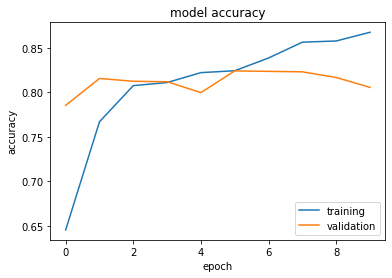

In [86]:
# plot scores

plt.plot(History[0]['accuracy'])
plt.plot(History[0]['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

## Final scores after k-fold cv

In [87]:
y_val = np.concatenate(y_true).astype(np.int64)
y_pred = np.concatenate(y_predicted).astype(np.int64)
accuracy = accuracy_score(y_val, y_pred)
f2_score = fbeta_score(y_val, y_pred, beta=2, average='macro')
print(f'Final scores: accuracy = {accuracy.round(2)} and F2_score = {f2_score.round(2)}') 

Final scores: accuracy = 0.81 and F2_score = 0.71


In [88]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.59      0.50      0.54       466
           1       0.78      0.78      0.78      1443
           2       0.87      0.68      0.76       773
           3       0.86      0.95      0.90      2658
           4       0.72      0.61      0.66       316

    accuracy                           0.81      5656
   macro avg       0.76      0.71      0.73      5656
weighted avg       0.81      0.81      0.81      5656



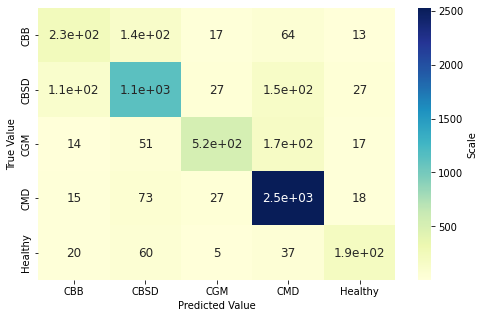

In [89]:
cm = confusion_matrix(y_val,y_pred)
labels = ['CBB','CBSD','CGM','CMD','Healthy']
plt.figure(figsize = (8,5))
sns.heatmap(cm, 
            xticklabels=labels,
            yticklabels=labels,
            annot=True,cmap="YlGnBu",annot_kws={"size": 12},cbar_kws={'label': 'Scale'}
            )
plt.ylabel("True Value"), 
plt.xlabel("Predicted Value")
plt.show()

# Prediction on the test set

In [ ]:
y_test_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_prob,axis=1)
accuracy = accuracy_score(y_test, y_test_pred)
f2_score = fbeta_score(y_test, y_test_pred, beta=2, average='macro')
print(f'Final scores: accuracy = {accuracy.round(2)} and F2_score = {f2_score.round(2)}') 

In [55]:

loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print(f'loss: {round(loss,2)} and accuracy: {round(acc,2)}')

18/18 [==============================] - 4s 129ms/step - loss: 1.1052 - accuracy: 0.6095
loss: 1.11 and accuracy: 0.61
